In [19]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

2022-11-21 12:37:27.419838: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# !wget https://github.com/alexeygrigorev/dino-or-dragon/releases/download/data/dino-dragon.zip
# !unzip dino-dragon.zip

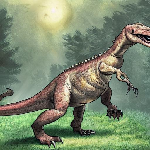

In [72]:
sample = load_img("./dino_dragon/train/dino/01d2e297-ae2b-41c0-833b-688f51ce5f22.jpg", target_size=(150, 150))
sample

In [80]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    "./dino_dragon/train/",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=20,
    shuffle=True
)

val_ds = val_gen.flow_from_directory(
    "./dino_dragon/test/",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=20,
    shuffle=True
)

print(train_ds.class_indices)

X, y = next(train_ds)
print(X.shape)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.
{'dino': 0, 'dragon': 1}
(20, 150, 150, 3)


In [81]:
# model creation

def make_model():
    inputs = tf.keras.Input(shape=(150, 150, 3))

    cnn_layer = tf.keras.layers.Conv2D(
                                        filters=32,
                                        kernel_size=(3, 3),
                                        activation="relu",
                                    )(inputs)

    pooling = tf.keras.layers.MaxPooling2D(
                                            pool_size=(2, 2)
                                    )(cnn_layer)

    flatten = tf.keras.layers.Flatten()(pooling)

    inner = tf.keras.layers.Dense(64, activation="relu")(flatten)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(inner)

    model = tf.keras.Model(inputs, outputs)

    ###########################################################################

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)

    # Question 1
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [61]:
# Question 2
print(model.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 175232)            0         
                                                                 
 dense_14 (Dense)            (None, 64)                11214912  
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                           

In [95]:
model = make_model()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "hw-8-{epoch:02d}-{accuracy:.3f}.h5",
    save_best_only=True,
    monitor="accuracy",
    mode="max"
)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
#     callbacks=[checkpoint]
)

Epoch 1/10
80/80 [==============================] - 7s 80ms/step - loss: 0.6700 - accuracy: 0.6280 - val_loss: 0.5922 - val_accuracy: 0.6878
Epoch 2/10
80/80 [==============================] - 6s 80ms/step - loss: 0.5288 - accuracy: 0.7597 - val_loss: 0.4617 - val_accuracy: 0.8096
Epoch 3/10
80/80 [==============================] - 7s 81ms/step - loss: 0.4387 - accuracy: 0.8181 - val_loss: 0.3867 - val_accuracy: 0.8426
Epoch 4/10
80/80 [==============================] - 6s 79ms/step - loss: 0.3604 - accuracy: 0.8563 - val_loss: 0.3480 - val_accuracy: 0.8426
Epoch 5/10
80/80 [==============================] - 7s 87ms/step - loss: 0.3170 - accuracy: 0.8764 - val_loss: 0.3361 - val_accuracy: 0.8579
Epoch 6/10
80/80 [==============================] - 7s 84ms/step - loss: 0.2974 - accuracy: 0.8789 - val_loss: 0.4540 - val_accuracy: 0.8020
Epoch 7/10
80/80 [==============================] - 7s 81ms/step - loss: 0.2657 - accuracy: 0.8915 - val_loss: 0.3142 - val_accuracy: 0.8655
Epoch 8/10
80

In [96]:
# Question 3
print("Median training accuracy", np.median(history.history['accuracy']))

Median training accuracy 0.8776662647724152


In [97]:
# Question 4
print("Standart deaviation on training losses", np.std(history.history['loss']))

Standart deaviation on training losses 0.14651713867746835


In [85]:
# Prediction
X = np.array([np.array(sample)])
model.predict(X)

1/1 [==============================] - 0s 81ms/step


array([[0.]], dtype=float32)

In [98]:
aug_train_gen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_train_ds = aug_train_gen.flow_from_directory(
    "./dino_dragon/train/",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=20,
    shuffle=True
)

# val_gen = ImageDataGenerator(rescale=1./255)

# val_ds = val_gen.flow_from_directory(
#     "./dino_dragon/test/",
#     target_size=(150, 150),
#     class_mode='binary',
#     batch_size=20,
#     shuffle=True
# )

Found 1594 images belonging to 2 classes.


In [99]:
history = model.fit(
    aug_train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
80/80 [==============================] - 12s 151ms/step - loss: 0.4652 - accuracy: 0.7817 - val_loss: 0.4340 - val_accuracy: 0.8020
Epoch 2/10
80/80 [==============================] - 11s 136ms/step - loss: 0.4282 - accuracy: 0.8036 - val_loss: 0.3812 - val_accuracy: 0.8401
Epoch 3/10
80/80 [==============================] - 12s 150ms/step - loss: 0.4214 - accuracy: 0.8080 - val_loss: 0.2895 - val_accuracy: 0.8731
Epoch 4/10
80/80 [==============================] - 11s 139ms/step - loss: 0.3936 - accuracy: 0.8243 - val_loss: 0.3701 - val_accuracy: 0.8325
Epoch 5/10
80/80 [==============================] - 11s 138ms/step - loss: 0.3709 - accuracy: 0.8450 - val_loss: 0.3375 - val_accuracy: 0.8731
Epoch 6/10
80/80 [==============================] - 12s 148ms/step - loss: 0.3720 - accuracy: 0.8356 - val_loss: 0.2548 - val_accuracy: 0.8985
Epoch 7/10
80/80 [==============================] - 11s 141ms/step - loss: 0.3922 - accuracy: 0.8237 - val_loss: 0.2660 - val_accuracy: 0.8985

In [101]:
# Question 5
print("Mean valid loss for the augmented model", np.mean(history.history['val_loss']))


Mean valid loss for the augmented model 0.3382696330547333


In [110]:
print("Avg val_accuracy of augmented model", np.mean(history.history["val_accuracy"][5:]))

Avg val_accuracy of augmented model 0.8680202841758728
